In [3]:
import glob
fs_cmb=sorted(glob.glob('/Users/mgrecu/GPM/ORO/2A-CS/2B*CONUS*HDF5'))
fs_1GMI=sorted(glob.glob('/Users/mgrecu/GPM/ORO/2A-CS/1C*CONUS*HDF5'))
print(len(fs_cmb))
print(len(fs_1GMI))
#stop
import netCDF4 as nc
from pyresample import kd_tree, geometry
from pyresample.kd_tree import resample_nearest, resample_gauss, resample_custom
def readCMB(fname): # reads relevant data from the CMB file
    fh_cmb=nc.Dataset(fname)
    qv=fh_cmb["KuKaGMI/vaporDensity"][:,:,:]
    press=fh_cmb["KuKaGMI/airPressure"][:,:,:]
    envNodes=fh_cmb["KuKaGMI/envParamNode"][:,:,:]
    airTemp=fh_cmb["KuKaGMI/airTemperature"][:,:,:]
    skTemp=fh_cmb["KuKaGMI/skinTemperature"][:,:]
    binNodes=fh_cmb["KuKaGMI/phaseBinNodes"][:,:]
    pwc=fh_cmb["KuKaGMI/precipTotWaterCont"][:,:,:]
    precipTotRate=fh_cmb["KuKaGMI/precipTotRate"][:,:,:]
    sfcEmiss=fh_cmb["KuKaGMI/surfEmissivity"][:,:,:]
    dm=fh_cmb["KuKaGMI/precipTotDm"][:,:,:]
    cldw=fh_cmb["KuKaGMI/cloudLiqWaterCont"][:,:,:]
    sfcBin=fh_cmb["KuKaGMI/Input/surfaceRangeBin"][:,:,:]
    zCorrected=fh_cmb["KuKaGMI/correctedReflectFactor"][:,:,:]
    pType=fh_cmb["KuKaGMI/Input/precipitationType"][:,:]
    lon=fh_cmb["KuKaGMI/Longitude"][:,:]
    lat=fh_cmb["KuKaGMI/Latitude"][:,:]
    return qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,precipTotRate

def readCMB_ray(fname,j): # reads relevant data from the CMB file
    fh_cmb=nc.Dataset(fname)
    qv=fh_cmb["KuKaGMI/vaporDensity"][:,j,:]
    press=fh_cmb["KuKaGMI/airPressure"][:,j,:]
    envNodes=fh_cmb["KuKaGMI/envParamNode"][:,j,:]
    airTemp=fh_cmb["KuKaGMI/airTemperature"][:,j,:]
    skTemp=fh_cmb["KuKaGMI/skinTemperature"][:,j]
    binNodes=fh_cmb["KuKaGMI/phaseBinNodes"][:,j]
    pwc=fh_cmb["KuKaGMI/precipTotWaterCont"][:,j,:]
    sfcEmiss=fh_cmb["KuKaGMI/surfEmissivity"][:,j,:]
    dm=fh_cmb["KuKaGMI/precipTotDm"][:,j,:]
    cldw=fh_cmb["KuKaGMI/cloudLiqWaterCont"][:,j,:]
    sfcBin=fh_cmb["KuKaGMI/Input/surfaceRangeBin"][:,j,:]
    zCorrected=fh_cmb["KuKaGMI/correctedReflectFactor"][:,j,:]
    pType=fh_cmb["KuKaGMI/Input/precipitationType"][:,j]
    lon=fh_cmb["KuKaGMI/Longitude"][:,j]
    lat=fh_cmb["KuKaGMI/Latitude"][:,j]
    simTb=fh_cmb["KuKaGMI/simulatedBrightTemp"][:,j,:]
    #print(fh_cmb["KuKaGMI/Input/"])
    surfaceType=fh_cmb["KuKaGMI/Input/surfaceType"][:,j]
    precipTotRate=fh_cmb["KuKaGMI/precipTotRate"][:,j,:]
    return qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,surfaceType,simTb,precipTotRate

def read1CGMI(fname): # reads relevant data from the 1C GMI file
    with nc.Dataset(fname) as f:
        #print(f)
        #print(f['S1'])
        lat_s1=f['S1/Latitude'][:]
        lon_s1=f['S1/Longitude'][:]
        tc_s1=f['S1/Tc'][:]
        lat_s2=f['S2/Latitude'][:]
        lon_s2=f['S2/Longitude'][:]
        tc_s2=f['S2/Tc'][:]
        sc_orient=f['S1/SCstatus/SCorientation'][:]
        sc_lat=f['S1/SCstatus/SClatitude'][:]
        sc_lon=f['S1/SCstatus/SClongitude'][:]
    return lat_s1,lon_s1,tc_s1,lat_s2,lon_s2,tc_s2,sc_orient,sc_lat,sc_lon

659
734


In [ ]:
imatched=0
for f1 in fs_cmb:
    orb=f1.split('.')[-3]
    for f2 in fs_1GMI:
        if orb in f2:
            imatched+=1
    print(f1,f2)

print(imatched)

In [4]:
ntot=0
import numpy as np
j=24
ien=0
import matplotlib.pyplot as plt
import xarray as xr
scorientL=[]
for f in fs_cmb[:]:
    qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,sfcType,simTb,pRate=readCMB_ray(f,j)
    orb=f.split('.')[-3]
    imatched=0
    for f2 in fs_1GMI:
        if orb in f2:
            imatched=1
            lat_s1,lon_s1,tc_s1,lat_s2,lon_s2,tc_s2,sc_orient,sc_lat,sc_lon=read1CGMI(f2)
            scorientL.append([sc_orient.max(),sc_orient.min()])

            input_def = geometry.SwathDefinition(lons=lon_s1[:,:], lats=lat_s1[:,:])
            output_def = geometry.SwathDefinition(lons=lon[:,np.newaxis], lats=lat[:,np.newaxis])
# Resample the tb_s1 data to the CMB grid using gaussian resampling
            wf = lambda r: 1 - r/20000.0
            tb_s1_resampled = resample_custom(input_def, tc_s1[:,:,:], output_def, radius_of_influence=30000, neighbours=10, weight_funcs=[wf for k in range(9)], fill_value=None)
            input_def = geometry.SwathDefinition(lons=lon_s2[:,:], lats=lat_s2[:,:])
            tb_s2_resampled = resample_custom(input_def, tc_s2[:,:,:], output_def, radius_of_influence=30000, neighbours=10, weight_funcs=[wf for k in range(4)], fill_value=None)
            
            break
    #break
    if imatched==0:
        continue
    pType=(pType/1e7).astype(int)
    #break
    a=np.nonzero(pType[:]>0)
    if len(a[0])<10:
        continue
    sc_orient_dpr=[]
    for i in a[0]:
        i1=np.argmin(np.abs(sc_lat-lat[i])+np.abs(sc_lon-lon[i]))
        sc_orient_dpr.append(sc_orient[i1])
    plt.pcolormesh(zCorrected[a[0],:,0].T,vmin=0,vmax=50,cmap='jet')
    plt.ylim(87,40)
    plt.savefig('Images/fig'+str(ien)+'.png')
    plt.close('all')
    ien+=1
    ntot+=len(a[0])
    tc_a=xr.DataArray(np.concatenate((tb_s1_resampled[:,0,:],tb_s2_resampled[:,0,:]),axis=1),dims=['all_scan','n13'],coords={'all_scan':range(pType.shape[0]),'n13':np.arange(13)})
    sc_orient_a=xr.DataArray(sc_orient_dpr,dims=['scan'],coords={'scan':a[0]})
    simTb_a=xr.DataArray(simTb[a[0],:],dims=['scan','nchan'],coords={'scan':a[0],'nchan':np.arange(13)})
    qv_a=xr.DataArray(qv[a[0],:],dims=['scan','n9'],coords={'scan':a[0],'n9':np.arange(10)})
    press_a=xr.DataArray(press[a[0],:],dims=['scan','n9'],coords={'scan':a[0],'n9':np.arange(10)})
    envNodes_a=xr.DataArray(envNodes[a[0],:],dims=['scan','n9'],coords={'scan':a[0],'n9':np.arange(10)})
    airTemp_a=xr.DataArray(airTemp[a[0],:],dims=['scan','n9'],coords={'scan':a[0],'n9':np.arange(10)})
    skTemp_a=xr.DataArray(skTemp[a[0]],dims=['scan'],coords={'scan':a[0]})
    binNodes_a=xr.DataArray(binNodes[a[0]],dims=['scan','n5'],coords={'scan':a[0],'n5':np.arange(5)})
    pwc_a=xr.DataArray(pwc[a[0],:],dims=['scan','nbins'],coords={'scan':a[0],'nbins':np.arange(88)})
    pRate_a=xr.DataArray(pRate[a[0],:],dims=['scan','nbins'],coords={'scan':a[0],'nbins':np.arange(88)})
    sfcEmiss_a=xr.DataArray(sfcEmiss[a[0],:],dims=['scan','nchan'],coords={'scan':a[0],'nchan':np.arange(13)})
    dm_a=xr.DataArray(dm[a[0],:],dims=['scan','nbins'],coords={'scan':a[0],'nbins':np.arange(88)})
    cldw_a=xr.DataArray(cldw[a[0],:],dims=['scan','nbins'],coords={'scan':a[0],'nbins':np.arange(88)})
    sfcBin_a=xr.DataArray(sfcBin[a[0],0],dims=['scan'],coords={'scan':a[0]})
    zCorrected_a=xr.DataArray(zCorrected[a[0],:,:],dims=['scan','nbins','nf'],coords={'scan':a[0],'nbins':np.arange(88),'nf':np.arange(2)})
    pType_a=xr.DataArray(pType[a[0]],dims=['scan'],coords={'scan':a[0]})
    lon_a=xr.DataArray(lon[a[0]],dims=['scan'],coords={'scan':a[0]})
    lat_a=xr.DataArray(lat[a[0]],dims=['scan'],coords={'scan':a[0]})
    sfcType_a=xr.DataArray(sfcType[a[0]],dims=['scan'],coords={'scan':a[0]})
    ds=xr.Dataset({'qv':qv_a,'press':press_a,'envNodes':envNodes_a,'airTemp':airTemp_a,'skTemp':skTemp_a,'binNodes':binNodes_a,'pwc':pwc_a,'sfcEmiss':sfcEmiss_a,'dm':dm_a,'cldw':cldw_a,'sfcBin':sfcBin_a,'zCorrected':zCorrected_a,'pType':pType_a,'lon':lon_a,'lat':lat_a,'sfcType':sfcType_a,'tc':tc_a, 'simTb':simTb_a,'sc_orient':sc_orient_a,'pRate':pRate_a})
    compLev=5
    encoding = {var: {'zlib': True, 'complevel': compLev} for var in ds.data_vars}
    ds.to_netcdf('subsets/CORRA_CONUS_subset%3.3i.nc'%ien,encoding=encoding)
    
    # https://github.com/HamedBaghal/One_Dimensional_PSWFs

/Users/mgrecu/miniforge3/lib/python3.10/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  get_neighbour_info(source_geo_def,


In [32]:
print(sc_orient.shape)
print(input_def)

(329,)
Shape: (329, 221)
Lons: [[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
Lats: [[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


(array([398.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       254.]), array([  0. ,   1.8,   3.6,   5.4,   7.2,   9. ,  10.8,  12.6,  14.4,
        16.2,  18. ,  19.8,  21.6,  23.4,  25.2,  27. ,  28.8,  30.6,
        32.4,  34.2,  36. ,  37.8,  39.6,  41.4,  43.2,  45. ,  46.8,
        48.6,  50.4,  52.2,  54. ,  55.8,  57.6,  59.4,  61.2,  63. ,
        64.8,  66.6,  68.4,  70.2,  72. ,  73.8

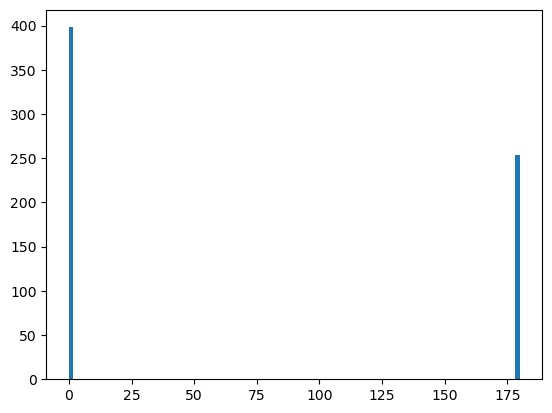

In [28]:
scorientL=np.array(scorientL)
print(plt.hist(scorientL[:,0],bins=100))

In [6]:
print(tc_s2.shape)

(329, 221, 4)


In [37]:
print(f.split('.')[-3])    

032082
